### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression

### Prepare data

#### Input and delete uneccessary data

In [3]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.shape

(289, 1147)

In [4]:
# Calculate the total case of each country/region
df = df.groupby('Country/Region').sum()

# Delete uneccessary coulumn: Province/State, Lat, Long
df.drop(columns = ['Province/State', 'Lat', 'Long'], inplace=True)

# add index
df.reset_index(inplace=True)

df.shape

(201, 1144)

#### Choose top 3 countries having most infection cases

In [5]:
# Choose top 3 values on Total Cases
top_values = df.iloc[:,-1].nlargest(3).tolist()

# Filter the rows and results in dataframe
top_rows = df[df.iloc[:,-1].isin(top_values)]

df = top_rows
df

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
63,France,0,0,2,3,3,3,4,5,5,...,39827175,39831700,39835896,39839090,39839090,39839090,39847236,39854299,39860410,39866718
80,India,0,0,0,0,0,0,0,0,1,...,44687837,44688105,44688388,44688722,44689046,44689327,44689593,44689919,44690298,44690738
186,US,1,1,2,2,5,5,5,6,6,...,103443455,103533872,103589757,103648690,103650837,103646975,103655539,103690910,103755771,103802702


#### Change dataset format

In [6]:
# Melt to long format
df = pd.melt(df, id_vars=['Country/Region'], var_name = 'date', value_name = 'infections')
df.head()


,Country/Region,date,infections
0,France,1/22/20,0
1,India,1/22/20,0
2,US,1/22/20,1
3,France,1/23/20,0
4,India,1/23/20,0


#### Group 7 days into week

In [7]:
# Convert date column to datetime:
df['date'] = pd.to_datetime(df['date'])

# Calculate days since start
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Truncate to week start by floor dividing days by 7
df['week'] = df['days_since_start'] // 7 + 1

df


,Country/Region,date,infections,days_since_start,week
0,France,2020-01-22,0,0,1
1,India,2020-01-22,0,0,1
2,US,2020-01-22,1,0,1
3,France,2020-01-23,0,1,1
4,India,2020-01-23,0,1,1
...,...,...,...,...,...
3424,India,2023-03-08,44690298,1141,164
3425,US,2023-03-08,103755771,1141,164
3426,France,2023-03-09,39866718,1142,164
3427,India,2023-03-09,44690738,1142,164


#### Calculate the infection cases for each week

In [8]:
# The final day of each week
df['max_day'] = df.groupby(['week'])['days_since_start'].transform('max')

# Value of final day of each week
df['max_infections'] = df.groupby(['Country/Region','week'])['infections'].transform('max')

# Previous max infections: return the max value of each week, group it again by 'Country/Region', shift it to the previous week, turn NaN to 0.
prev_max = df.groupby(['Country/Region','week'])['infections'].max().groupby(level=0).shift(1).fillna(0).reset_index()

# add previous max infections on df
df = df.merge(prev_max, on=['Country/Region','week'])

# calculte value of each individual week
df['week_value'] = df['max_infections'] - df['infections_y']

df = df.groupby(['Country/Region','week'])['week_value'].max().reset_index()

df_week = df.copy()
df_week

,Country/Region,week,week_value
0,France,1,4.0
1,France,2,2.0
2,France,3,5.0
3,France,4,1.0
4,France,5,2.0
...,...,...,...
487,US,160,257530.0
488,US,161,264445.0
489,US,162,244786.0
490,US,163,247455.0


#### Handling with outliers

Text(0.5, 1.0, '')

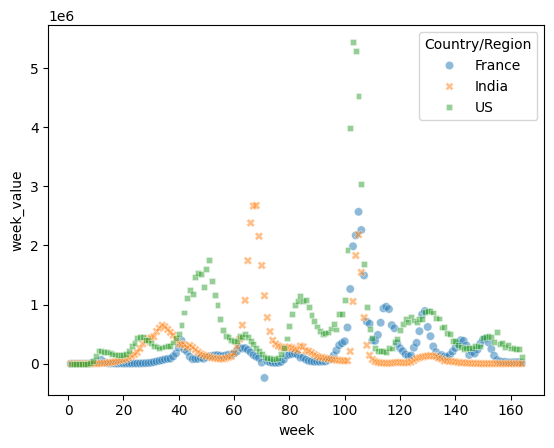

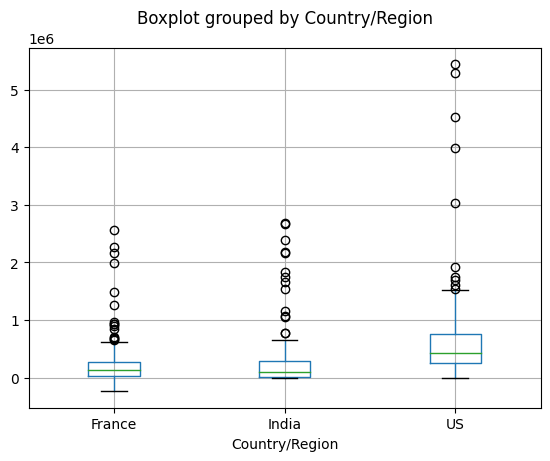

In [9]:
sns.scatterplot(x='week', y='week_value', hue='Country/Region', data=df_week, style='Country/Region', alpha = 0.5)

df_week.boxplot(column = 'week_value', by = 'Country/Region')
plt.title('')

In [10]:
by_country_week = df_week.drop(columns = 'week').groupby('Country/Region')
outliers = pd.DataFrame()

for country, group in by_country_week:
  Q1 = group['week_value'].quantile(0.25)
  Q3 = group['week_value'].quantile(0.75)
  IQR = Q3 - Q1
  minimun = Q1 - 1.5*IQR
  maximun = Q3 + 1.5*IQR

  outliers_subset = group[(group['week_value'] < minimun) | (group['week_value'] > maximun)]

  outliers = pd.concat([outliers, outliers_subset])

outliers

,Country/Region,week_value
101,France,1263975.0
102,France,1985976.0
103,France,2170668.0
104,France,2569121.0
105,France,2260662.0
106,France,1493369.0
107,France,711735.0
108,France,677259.0
112,France,694115.0
113,France,935432.0


In [11]:
mask = ~(
         df_week['week_value'].isin(outliers['week_value']))
df_week = df_week[mask].reset_index(drop=True)

df_week

,Country/Region,week,week_value
0,France,1,4.0
1,France,2,2.0
2,France,3,5.0
3,France,4,1.0
4,France,5,2.0
...,...,...,...
448,US,160,257530.0
449,US,161,264445.0
450,US,162,244786.0
451,US,163,247455.0


Text(0.5, 1.0, '')

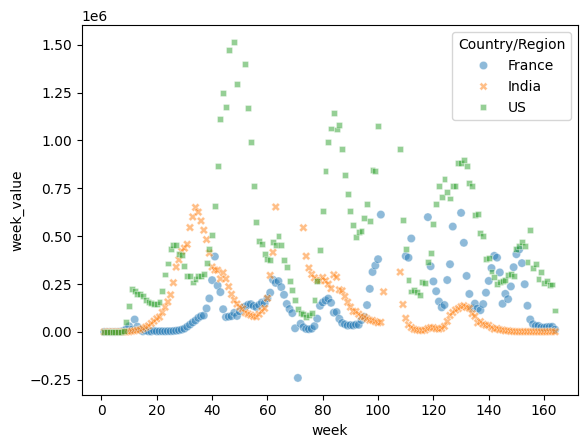

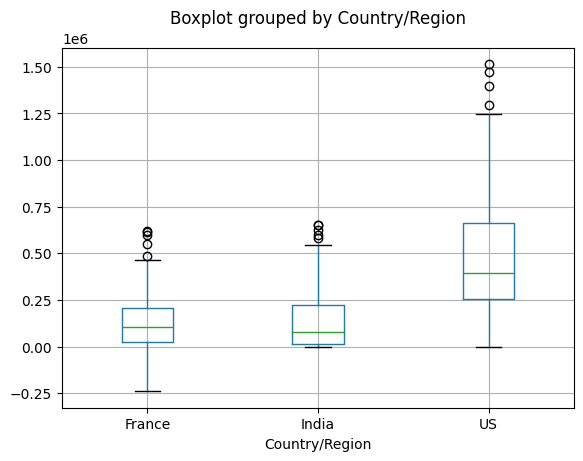

In [12]:
sns.scatterplot(x='week', y='week_value', hue='Country/Region', data=df_week, style='Country/Region', alpha = 0.5)

df_week.boxplot(column = 'week_value', by = 'Country/Region')
plt.title('')

 ### Fit a linear regression model

In [13]:
df_week

,Country/Region,week,week_value
0,France,1,4.0
1,France,2,2.0
2,France,3,5.0
3,France,4,1.0
4,France,5,2.0
...,...,...,...
448,US,160,257530.0
449,US,161,264445.0
450,US,162,244786.0
451,US,163,247455.0


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
standardScaler = StandardScaler()
columns_to_scale = ["week_value"]
df_week[columns_to_scale] = standardScaler.fit_transform(df_week[columns_to_scale])

In [16]:
# Split data into country groups
country_groups = df_week.groupby('Country/Region')

In [17]:
# Fit models
models = {}
r_squared = {}
r2 ={}
rss ={}
MSE ={}
for name, group in country_groups:
  # Define x_axis
  X = group['week'].to_numpy()
  X = X[:, np.newaxis]

  # Define y_axis
  y = group['week_value'].to_numpy()

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

  # Fit model
  lr = LinearRegression().fit(X_train, y_train)
  models[name] = lr

  # Loss function
  r_squared[name] = lr.score(X_test, y_test)
  rss[name] = np.mean((lr.predict(X_test) - y_test) ** 2)

  y_pred = lr.predict(X_test)
  r2[name] = r2_score(y_test, y_pred)

  MSE[name] = mean_squared_error(y_test, y_pred)

In [18]:
print(r_squared)
print(rss)
print(r2)
print(MSE)

{'France': 0.2311102487803638, 'India': 0.061307506496349085, 'US': -0.013256124291134652}
{'France': 0.22308670060093247, 'India': 0.37350800637555037, 'US': 1.1874237876575813}
{'France': 0.2311102487803638, 'India': 0.061307506496349085, 'US': -0.013256124291134652}
{'France': 0.22308670060093247, 'India': 0.37350800637555037, 'US': 1.1874237876575813}


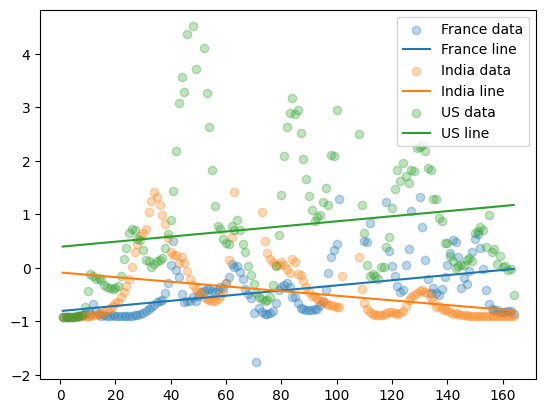

In [19]:
# Plot each group
for name, group in country_groups:

   plt.scatter(group['week'], group['week_value'], label=name + ' data', alpha = 0.3)

   X_plot = np.linspace(group['week'].min(), group['week'].max())

   plt.plot(X_plot, models[name].predict(X_plot[:,np.newaxis]),
            label=name + ' line')

plt.legend()
plt.show()